# Feature Validation Analysis - Scalp EEG

Here, we run through a validation analysis of scalp EEG data for the purposes of predicting epilepsy.

In [1]:
# comment if you don't have nb_black installed
#%load_ext lab_black

In [1]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
import warnings

warnings.filterwarnings("ignore")

import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    StratifiedGroupKFold,
    StratifiedShuffleSplit,
    cross_validate,
)

from sklearn.utils import resample

import mne

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals

from eztrack.io import read_derivative_npy

# if you installed sporf via README
# from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sample_code.features import (
    calculate_distribution,
    calculate_entropy,
    calculate_variance,
    calculate_kl_div,
    calculate_skew,
    calculate_kurtosis,
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sklearn

# this should be at least 1.0
print(sklearn.__version__)

1.1.dev0


In [3]:
from sklearn import preprocessing

enc = preprocessing.OrdinalEncoder()

## Define Run Parameters

In [58]:
# Group name keys, assigned y-label values
experimental_condition_map = {
    "non-epilepsy-normal-eeg": 0,
    "epilepsy-normal-eeg": 1,
    "epilepsy-abnormal-eeg": 1,
}

reference = "monopolar"
radius = "1.25"

remove_C3C4 = False
alpha_O1O2 = True

include_centers = ['jhh']

# Define possible helper functions

In [5]:
class NumpyEncoder(json.JSONEncoder):
    """Special json encoder for numpy types.

    Pass to json.dump(), or json.load().
    """

    def default(self, obj):  # noqa
        if isinstance(
            obj,
            (
                np.int_,
                np.intc,
                np.intp,
                np.int8,
                np.int16,
                np.int32,
                np.int64,
                np.uint8,
                np.uint16,
                np.uint32,
                np.uint64,
            ),
        ):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):  # This is the fix
            return obj.tolist()
        elif isinstance(obj, (datetime, date)):
            return obj.isoformat()
        return json.JSONEncoder.default(self, obj)

In [6]:
def plot_subject_feature_map(dataset, desired_subject, feature_name):
    for idx, subject in enumerate(dataset["subject"]):
        if subject != desired_subject:
            continue

        # get the metadata
        ch_names = dataset["ch_names"][idx]

        # get the data
        feature_map = dataset[feature_name][idx]

        x = np.arange(feature_map.shape[1])

        sns.set_context("paper", font_scale=1.75)
        fig, ax = plt.subplots()

        y_mean = feature_map.mean(axis=0)
        y_sem = scipy.stats.sem(feature_map, axis=0)
        ax.plot(x, y_mean, color="red")
        ax.fill_between(x, y_mean - y_sem, y_mean + y_sem, color="red", alpha=0.5)

        ax.set(
            title=f"Subject {subject} - {feature_name}",
            xlabel="Time (A.U.)",
            ylabel=f"{feature_name} Value",
        )
        ax.legend()
        break

In [7]:
def _load_subject_derivs(
    deriv_path, read_func, subjects=None, search_str="*.npy", dataset=None
):
    if subjects is None:
        subjects = get_entity_vals(deriv_path, "subject")

    print(f"Loading data for subjects: {subjects}")

    if dataset is None:
        dataset = collections.defaultdict(list)
    for subject in subjects:
        subj_path = deriv_path / f"sub-{subject}"

        # get all files of certain search_str
        fpaths = subj_path.glob(search_str)

        # now load in all file paths
        for fpath in fpaths:
            deriv = read_func(fpath, source_check=False)

            bids_params = get_entities_from_fname(fpath.name, on_error="ignore")
            session = bids_params["session"]
            task = bids_params["task"]
            run = bids_params["run"]

            # extract data
            ch_names = deriv.ch_names
            deriv_data = deriv.get_data()

            dataset["subject"].append(subject)
            dataset["data"].append(deriv_data)
            dataset["ch_names"].append(ch_names)
            dataset["session"].append(session)
            dataset["task"].append(task)
            dataset["run"].append(run)

    return dataset

In [8]:
def _get_exp_condition(subject, root):
    part_fname = os.path.join(root, "participants.tsv")
    df = pd.read_csv(part_fname, sep="\t")
    if not subject.startswith("sub-"):
        subject = f"sub-{subject}"

    return df[df["participant_id"] == subject]

In [10]:
def _features_from_spatiotemporal_heatmap(deriv_data):
    # Calculate distribution of values over time for the spatiotemporal heatmap
    """distribution = calculate_distribution(deriv_data)
    # Calculate features from this distribution
    entropy = calculate_entropy(distribution)
    variance = calculate_variance(distribution)
    kldiv = calculate_kl_div(distribution)
    skew = calculate_skew(distribution)
    kurtosis = calculate_kurtosis(distribution)
    features = [entropy, variance, kldiv, skew, kurtosis]"""
    features = np.hstack(
        (
            deriv_data.mean(axis=1),
            deriv_data.std(axis=1),
        ),
        #         axis=0,
    )
    return features

In [11]:
def get_Xy_matrix(dataset, feature_set):
    X = []
    y = []
    subjects = []

    for idx, subject in enumerate(dataset["subject"]):
        X_buff = []
        for feature_name in feature_set:
            feature = dataset[feature_name][idx]
            if isinstance(feature, float):
                feat = [feature]
            elif isinstance(feature, np.ndarray):
                feat = list(feature)
            else:
                feat = feature
            feat = [feature] if isinstance(feature, float) else feature
            X_buff.extend(feat)
        X_buff = np.array(X_buff)

        X.append(X_buff)
        y.append(dataset["group"][idx] > 0)
        subjects.append(subject)
    return X, y, subjects

In [12]:
def convert_experimental_cond_to_y(experimental_condition_list):
    return [experimental_condition_map[cond] for cond in experimental_condition_list]

In [13]:
def _filter_spike_patients(dataset, spike_classify_df):
    filtered_dataset = collections.defaultdict(list)
    for idx in range(len(dataset["subject"])):
        sub = dataset["subject"][idx]
        ses = dataset["session"][idx]
        task = dataset["task"][idx]
        run = dataset["run"][idx]
        data_params = [sub, ses, task, run]
        match = False
        for ind, spike_row in spike_classify_df.iterrows():
            print(spike_row)
            sub = spike_row["subject"]
            ses = spike_row["session"]
            task = spike_row["task"]
            run = spike_row["run"]
            spike_params = [sub, ses, task, run]
            if spike_params == data_params:
                match = True
        if not match:
            filtered_dataset["subject"].append(dataset["subject"][idx])
            filtered_dataset["session"].append(dataset["session"][idx])
            filtered_dataset["task"].append(dataset["task"][idx])
            filtered_dataset["run"].append(dataset["run"][idx])
            filtered_dataset["data"].append(dataset["data"][idx])
            filtered_dataset["ch_names"].append(dataset["ch_names"][idx])
    return filtered_dataset

In [14]:
def add_spike_positives(scores, spike_classify_df):
    """Creates an additional fold with dummy values except for subjects."""
    nsubs = len(spike_classify_df.index)
    scores["fit_time"] = list(scores["fit_time"])
    scores["fit_time"].append(0.0)
    scores["score_time"] = list(scores["score_time"])
    scores["score_time"].append(0.0)
    scores["test_roc_auc"] = list(scores["test_roc_auc"])
    scores["test_roc_auc"].append(0.0)
    scores["train_roc_auc"] = list(scores["train_roc_auc"])
    scores["train_roc_auc"].append(0.0)
    scores["test_accuracy"] = list(scores["test_accuracy"])
    scores["test_accuracy"].append(0.0)
    scores["train_accuracy"] = list(scores["train_accuracy"])
    scores["train_accuracy"].append(0.0)
    scores["test_balanced_accuracy"] = list(scores["test_balanced_accuracy"])
    scores["test_balanced_accuracy"].append(0.0)
    scores["train_balanced_accuracy"] = list(scores["train_balanced_accuracy"])
    scores["train_balanced_accuracy"].append(0.0)
    scores["test_average_precision"] = list(scores["test_average_precision"])
    scores["test_average_precision"].append(0.0)
    scores["train_average_precision"] = list(scores["train_average_precision"])
    scores["train_average_precision"].append(0.0)
    scores["test_precision"] = list(scores["test_precision"])
    scores["test_precision"].append(0.0)
    scores["train_precision"] = list(scores["train_precision"])
    scores["train_precision"].append(0.0)
    scores["test_neg_brier_score"] = list(scores["test_neg_brier_score"])
    scores["test_neg_brier_score"].append(0.0)
    scores["train_neg_brier_score"] = list(scores["train_neg_brier_score"])
    scores["train_neg_brier_score"].append(0.0)
    scores["test_recall"] = list(scores["test_recall"])
    scores["test_recall"].append(0.0)
    scores["train_recall"] = list(scores["train_recall"])
    scores["train_recall"].append(0.0)
    scores["test_f1"] = list(scores["test_f1"])
    scores["test_f1"].append(0.0)
    scores["train_f1"] = list(scores["train_f1"])
    scores["train_f1"].append(0.0)
    scores["test_fraction_pos"].append([1.0] * len(scores["test_fraction_pos"][0]))
    scores["test_mean_pred_value"].append(
        [1.0] * len(scores["test_mean_pred_value"][0])
    )
    scores["test_fpr"].append([0.0] * int(nsubs / 2))
    scores["test_tpr"].append([0.0] * int(nsubs / 2))
    scores["test_fnr"].append([0.0] * int(nsubs / 2))
    scores["test_tnr"].append([0.0] * int(nsubs / 2))
    scores["test_thresholds"].append([0.0] * int(nsubs / 2))
    scores["train_fraction_pos"].append([])
    scores["train_mean_pred_value"].append([])
    scores["train_fpr"].append([])
    scores["train_tpr"].append([])
    scores["train_fnr"].append([])
    scores["train_tnr"].append([])
    scores["train_thresholds"].append([])
    scores["train_subjects"].append([])
    scores["train_sessions"].append([])
    scores["train_tasks"].append([])
    scores["train_runs"].append([])
    scores["train_y_pred_proba"].append([])
    scores["test_subjects"].append(spike_classify_df["subject"].tolist())
    scores["test_sessions"].append(spike_classify_df["session"].tolist())
    scores["test_tasks"].append(spike_classify_df["task"].tolist())
    scores["test_runs"].append(spike_classify_df["run"].tolist())
    scores["test_y_pred_proba"].append([1] * nsubs)
    scores["test_specificity"].append(0.0)
    return scores

# Define data directories

In [13]:
jhroot = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
jeffroot = Path("D:/OneDriveParent/Johns Hopkins/Jefferson_Scalp - Documents/root")

# not ready yet
upmcroot = Path(
    "D:/OneDriveParent/Johns Hopkins/UPMC_Scalp - Documents/scalp_study/root"
)

In [59]:
jh_deriv_root = jhroot / "derivatives"
jeff_deriv_root = jeffroot / "derivatives"
jh_source_root = jhroot / "sourcedata"
jeff_source_root = jeffroot / "sourcedata"

# define derivative chains
ss_deriv_chain = Path("sourcesink") / reference
#remove_C3C4 = False
#alpha_O1O2 = False
if alpha_O1O2:
    ss_deriv_chain = ss_deriv_chain / "filter-alpha_O1O2"
if remove_C3C4:
    ss_deriv_chain = ss_deriv_chain / "remove-C3C4"

frag_deriv_chain = Path("fragility") / f"radius{radius}" / reference
if alpha_O1O2:
    frag_deriv_chain = frag_deriv_chain / "filter-alpha_O1O2"
if remove_C3C4:
    frag_deriv_chain = frag_deriv_chain / "remove-C3C4"

# define final path
jh_ss_deriv_dir = jh_deriv_root / ss_deriv_chain
jeff_ss_deriv_dir = jeff_deriv_root / ss_deriv_chain
jh_frag_deriv_dir = jh_deriv_root / frag_deriv_chain
jeff_frag_deriv_dir = jeff_deriv_root / frag_deriv_chain

combined_deriv_dir = Path(
    "D:/OneDriveParent/OneDrive - Johns Hopkins/Scalp_EEG_combined/derivatives"
)

In [32]:
print(jh_ss_deriv_dir)

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\remove-C3C4


## Load in spike model json

Determine which subjects were predicted positive from the spike model and exclude them from this analysis, adding them back in the end with P(epilepsy) = 1

In [46]:
n_splits=10
clf_name = "logreg"
fname = (
    combined_deriv_dir
    / f"cv{n_splits}_{clf_name}_mtry6_exp_abnormalspikes_meandiff.json"
)
with open(fname, "r") as fid:
    spike_scores = json.load(fid)

In [18]:
test_subjects = spike_scores['test_subjects']
test_subjects_ = [item for sublist in test_subjects for item in sublist]
test_sessions = spike_scores['test_sessions']
test_sessions_ = [item for sublist in test_sessions for item in sublist]
test_tasks = spike_scores['test_tasks']
test_tasks_ = [item for sublist in test_tasks for item in sublist]
test_runs = spike_scores['test_runs']
test_runs_ = [item for sublist in test_runs for item in sublist]
test_y_pred_proba = spike_scores['test_y_pred_proba']
test_y_pred_proba_ = [item for sublist in test_y_pred_proba for item in sublist]
spike_classify_df = pd.DataFrame()
spike_classify_df['subject'] = test_subjects_
spike_classify_df['session'] = test_sessions_
spike_classify_df['task'] = test_tasks_
spike_classify_df['run'] = test_runs_
spike_classify_df['y_pred_proba'] = test_y_pred_proba_
spike_classify_df = spike_classify_df[spike_classify_df['y_pred_proba'] > 0.7]
spike_classify_df

,subject,session,task,run,y_pred_proba
1,jhh110,None,None,01,0.999637
6,jeff205,1,None,1,0.999999
7,jeff201,1,None,6,0.866273
9,jhh227,None,None,01,1.000000
16,jhh214,None,None,01,0.975365
22,jeff205,1,None,1,0.996836
29,jeff208,1,None,1,0.802050
38,jeff202,1,None,2,0.710033
55,jeff205,1,None,1,0.997527
56,jhh214,None,None,01,0.978820


In [60]:
dataset = _load_subject_derivs(
    jh_ss_deriv_dir,
    read_func=read_derivative_npy,
    subjects=None,
    search_str="*desc-ssindmatrix*.npy",
)
"""dataset = _load_subject_derivs(
    jeff_ss_deriv_dir,
    read_func=read_derivative_npy,
    subjects=None,
    search_str="*desc-ssindmatrix*.npy",
    dataset=dataset,
)
dataset = _filter_spike_patients(dataset, spike_classify_df)"""

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh005\sub-jhh005_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh006\sub-jhh006_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh007\sub-jhh007_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh008\sub-jhh008_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh009\sub-jhh009_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh010\sub-jhh010_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh011\sub-jhh011_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh012\sub-jhh012_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh013\sub-jhh013_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh014\sub-jhh014_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh015\sub-jhh015_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh016\sub-jhh016_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh017\sub-jhh017_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh018\sub-jhh018_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh019\sub-jhh019_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh020\sub-jhh020_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh021\sub-jhh021_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh022\sub-jhh022_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh023\sub-jhh023_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh024\sub-jhh024_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh025\sub-jhh025_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh026\sub-jhh026_run-01_

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh027\sub-jhh027_task-asleep_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh027\sub-jhh027_task-awake_run-02_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh028\sub-jhh028_task-asleep_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh028\sub-jhh028_task-awake_run-02_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh029\sub-jhh029_task-awake_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh101\sub-jhh101_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh102\sub-jhh102_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh103\sub-jhh103_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh104\sub-jhh104_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh105\sub-jhh105_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh106\sub-jhh106_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh107\sub-jhh107_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh108\sub-jhh108_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh109\sub-jhh109_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh110\sub-jhh110_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh111\sub-jhh111_run-01_

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh112\sub-jhh112_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh113\sub-jhh113_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh114\sub-jhh114_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh115\sub-jhh115_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh116\sub-jhh116_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh117\sub-jhh117_run-01_

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh118\sub-jhh118_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh119\sub-jhh119_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh120\sub-jhh120_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh121\sub-jhh121_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh122\sub-jhh122_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh124\sub-jhh124_task-as

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh124\sub-jhh124_task-awake_run-02_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh125\sub-jhh125_task-asleep_run-02_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh125\sub-jhh125_task-awake_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh126\sub-jhh126_task-awake_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh127\sub-jhh127_task-asleep_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh201\sub-jhh201_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh202\sub-jhh202_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh203\sub-jhh203_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh204\sub-jhh204_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh205\sub-jhh205_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh206\sub-jhh206_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh207\sub-jhh207_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh208\sub-jhh208_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh209\sub-jhh209_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh210\sub-jhh210_run-01_

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh211\sub-jhh211_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh212\sub-jhh212_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh213\sub-jhh213_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh214\sub-jhh214_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh215\sub-jhh215_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh216\sub-jhh216_run-01_

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh218\sub-jhh218_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh219\sub-jhh219_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh220\sub-jhh220_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh221\sub-jhh221_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh222\sub-jhh222_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh223\sub-jhh223_run-01_

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh225\sub-jhh225_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh226\sub-jhh226_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh227\sub-jhh227_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh228\sub-jhh228_task-asleep_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jhh228\sub-jhh228_task-awake_run-02_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\filter-alpha_O1O2\sub-jh

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

'dataset = _load_subject_derivs(\n    jeff_ss_deriv_dir,\n    read_func=read_derivative_npy,\n    subjects=None,\n    search_str="*desc-ssindmatrix*.npy",\n    dataset=dataset,\n)\ndataset = _filter_spike_patients(dataset, spike_classify_df)'

## Optionally Load in Specific Excel Sheet

## Plot a single subject to test

(16, 783)


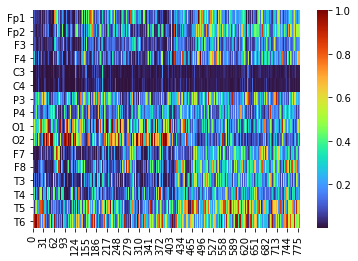

In [61]:
desired_subject = "jhh001"
feature_name = "ssentropy"

idx = dataset["subject"].index(desired_subject)
data = dataset["data"][idx]
ch_names = dataset["ch_names"][idx]
print(data.shape)


fig, ax = plt.subplots()
sns.heatmap(data, cmap="turbo", yticklabels=ch_names, ax=ax)

plt.show()

# Define Cross Validation Experiment

In [62]:
n_splits = 10
train_size = 0.7
random_state = 12345

In [63]:
cv = StratifiedGroupKFold(
    n_splits=n_splits,
    random_state=random_state,
    shuffle=True,
)
cv = StratifiedShuffleSplit(
    n_splits=n_splits,
    train_size=train_size,
    random_state=random_state,
)

## Form Features from SpatioTemporal Heatmaps

In [64]:
X = []
y = []
subjects = []
sessions = []
tasks = []
runs = []

for idx in range(len(dataset["subject"])):
    subject = dataset["subject"][idx]
    session = dataset["session"][idx]
    task = dataset["task"][idx]
    run = dataset["run"][idx]

    ch_names = dataset["ch_names"][idx]
    deriv_data = dataset["data"][idx]

    # extract features
    X_ = _features_from_spatiotemporal_heatmap(deriv_data)

    # extract outcome
    if "jhh" in subject:
        root = jhroot
    elif "jeff" in subject:
        root = jeffroot
    elif "upmc" in subject:
        root = upmcroot
    subj_df = _get_exp_condition(subject, root)
    outcome = subj_df["exp_condition"].values[0].strip()
    X.append(X_)
    y.append(outcome)
    subjects.append(subject)
    sessions.append(session)
    tasks.append(task)
    runs.append(run)
    
X = np.array(X)
y_encode = np.array(y)
subjects = np.array(subjects)
sessions = np.array(sessions)
tasks = np.array(tasks)
runs = np.array(runs)

print(X.shape, y_encode.shape)

(92, 32) (92,)


In [65]:
print(y)
y = np.array(convert_experimental_cond_to_y(y_encode))

print(X.shape)
print(y.shape)
print(y)

['non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'non-epilepsy-normal-eeg', 'epilepsy-normal-eeg', 'epilepsy-normal-eeg', 'epilepsy-normal-eeg', 'epilepsy-normal-eeg', 'epilepsy-normal-eeg', 'epilepsy-normal-eeg

## Define Classification Models

In [66]:
clf_name = "rf"
max_features = X.shape[1]
n_features = max_features

rf_model_params = {
    "n_estimators": 1000,
    "max_features": max_features,
    "n_jobs": -1,
    "random_state": random_state,
}
#lr_model_params = {"n_jobs": -1, "random_state": random_state}

In [67]:
if clf_name == "rf":
    clf = RandomForestClassifier(**rf_model_params)
elif clf_name == "sporf":
    # only used if you installed cysporf
    clf = ObliqueForestClassifier(**rf_model_params)
elif clf_name == "lr":
    clf = LogisticRegression(**lr_model_params)

# Run sklearn.cross_validate

In [68]:
scoring_funcs = {
    "roc_auc": roc_auc_score,
    "accuracy": accuracy_score,
    "balanced_accuracy": balanced_accuracy_score,
    "average_precision": average_precision_score,
    "precision": "",
    "neg_brier_score": brier_score_loss,
    "recall": "",
    "f1": "",
}

# run cross-validation
scores = cross_validate(
    clf,
    X,
    y,
    groups=None,
    cv=cv,
    scoring=list(scoring_funcs.keys()),
    return_estimator=True,
    return_train_score=True,
    n_jobs=1,
    error_score='raise'
)

# get the estimators
estimators = scores.pop("estimator")

In [69]:
print("Using estimator ", estimators[0])

# initialize keys to list
for key in [
    "test_fraction_pos",
    "test_mean_pred_value",
    "test_fpr",
    "test_tpr",
    "test_fnr",
    "test_tnr",
    "test_thresholds",
    "train_fraction_pos",
    "train_mean_pred_value",
    "train_y_pred_proba",
    "train_fpr",
    "train_tpr",
    "train_fnr",
    "train_tnr",
    "train_thresholds",
    "train_subjects",
    "test_subjects",
    "test_y_pred_proba",
    "test_importances",
    "test_specificity",
    "test_y",
    "test_y_encodings",
]:
    scores[key] = []

for idx, (train_inds, test_inds) in enumerate(cv.split(X, y)):
    estimator = estimators[idx]

    # append subjects
    scores["train_subjects"].append(subjects[train_inds])
    scores["test_subjects"].append(subjects[test_inds])
    scores["test_y"].append(y[test_inds])
    scores["test_y_encodings"].append(y_encode[test_inds])

    # evaluate on the test set
    y_train = y[train_inds]
    X_train = X[train_inds, :]
    [print(x,y) for x,y in zip(X_train, y_train)]
    y_pred_prob_ = estimator.predict_proba(X_train)
    print(y_pred_prob_)
    y_pred_prob = y_pred_prob_[:, 1]

    # compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_train, y_pred_prob, n_bins=10, strategy="quantile"
    )

    # append training data
    scores["train_y_pred_proba"].append(y_pred_prob)
    scores["train_fraction_pos"].append(fraction_of_positives)
    scores["train_mean_pred_value"].append(mean_predicted_value)

    # store ROC curve metrics on the held-out test set
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob, pos_label=1)
    fnr, tnr, neg_thresholds = roc_curve(y_train, y_pred_prob, pos_label=0)
    scores["train_fpr"].append(fpr)
    scores["train_tpr"].append(tpr)
    scores["train_fnr"].append(fnr)
    scores["train_tnr"].append(tnr)
    scores["train_thresholds"].append(thresholds)

    # evaluate on the test set
    y_test = y[test_inds]
    X_test = X[test_inds, :]
    y_pred_prob = estimator.predict_proba(X_test)[:, 1]

    # compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_prob, n_bins=10, strategy="quantile"
    )

    # append testing data
    scores["test_y_pred_proba"].append(y_pred_prob)
    scores["test_fraction_pos"].append(fraction_of_positives)
    scores["test_mean_pred_value"].append(mean_predicted_value)

    # store ROC curve metrics on the held-out test set
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    fnr, tnr, neg_thresholds = roc_curve(y_test, y_pred_prob, pos_label=0)
    scores["test_fpr"].append(fpr)
    scores["test_tpr"].append(tpr)
    scores["test_fnr"].append(fnr)
    scores["test_tnr"].append(tnr)
    scores["test_thresholds"].append(thresholds)

    tn, fp, fn, tp = confusion_matrix(
        y_test.astype(int), (y_pred_prob > 0.5).astype(int)
    ).ravel()
    scores["test_specificity"].append(tn / (tn + fp))

    # get the permutation importances
    r = permutation_importance(
        estimator, X_test, y_test, n_repeats=5, random_state=random_state, n_jobs=-1
    )
    scores["test_importances"].append(r.importances)

Using estimator  RandomForestClassifier(max_features=32, n_estimators=1000, n_jobs=-1,
                       random_state=12345)
[0.22745536 0.25724461 0.14212479 0.19280167 0.02209095 0.02246942
 0.27742704 0.20325836 0.3600348  0.35216703 0.20693598 0.24684807
 0.18986625 0.19944516 0.39049757 0.39043704 0.21019446 0.22497131
 0.11982304 0.18808063 0.03045731 0.03282647 0.20314007 0.16187567
 0.28127301 0.31216827 0.19671713 0.22263206 0.1800189  0.17131764
 0.2656061  0.25921208] 0
[0.30228453 0.31761472 0.17845215 0.1781581  0.02397443 0.02454081
 0.11969006 0.14440425 0.07181845 0.12029342 0.20300468 0.19185322
 0.22024755 0.20158295 0.35323073 0.5581708  0.26438277 0.24757709
 0.1761936  0.17254976 0.03471809 0.03680166 0.12536768 0.14145152
 0.08785217 0.15000112 0.18040345 0.16910829 0.20170139 0.17731159
 0.26263713 0.30993763] 1
[0.12573783 0.08256404 0.0799985  0.11293446 0.03424405 0.03498745
 0.13570486 0.19045833 0.33070734 0.4155745  0.25942342 0.32773539
 0.28956901 0.

[0.39946756 0.37139245 0.30715359 0.22157483 0.06892718 0.07651264
 0.26220473 0.09975874 0.10474264 0.10380301 0.46686161 0.30744275
 0.43365578 0.31462115 0.51300068 0.36007562 0.19853801 0.2059537
 0.18742689 0.1425409  0.06433602 0.06407552 0.16644491 0.08545955
 0.09931814 0.09996292 0.21300295 0.1825421  0.2006368  0.1827521
 0.24071806 0.22052764] 1
[0.22050011 0.18447221 0.251941   0.22914735 0.03192473 0.03391188
 0.24685365 0.17951253 0.15603955 0.19149676 0.2769877  0.21801287
 0.27033606 0.26728274 0.4330611  0.36933375 0.19649046 0.17120321
 0.21908474 0.20251517 0.04706979 0.05000032 0.21183585 0.17372476
 0.1778468  0.21857153 0.22851489 0.20664274 0.22735146 0.22956034
 0.29499654 0.26666556] 1
[0.16233651 0.19851319 0.09370249 0.13808871 0.01164344 0.01217486
 0.20426774 0.27881325 0.49756333 0.3580214  0.19319615 0.24390974
 0.19675113 0.20921494 0.47588658 0.57426414 0.12220307 0.14867549
 0.07756264 0.11908908 0.0107308  0.01366837 0.14138519 0.1658426
 0.2627848  0

[0.22850206 0.23860843 0.07874947 0.12330784 0.02552307 0.0259222
 0.20178855 0.17247883 0.21452006 0.45762117 0.28256554 0.19831414
 0.16902778 0.25850311 0.35421843 0.60178701 0.20654488 0.20205558
 0.07313943 0.11260494 0.03409963 0.03488369 0.16681882 0.13175452
 0.18924232 0.29820772 0.22729301 0.15843583 0.14699382 0.18865543
 0.24204867 0.2697529 ] 1
[0.24805703 0.23628089 0.2411348  0.22789618 0.02878215 0.02796501
 0.15510339 0.16916311 0.1094218  0.13246321 0.28639582 0.27593187
 0.25256289 0.31241119 0.41069327 0.51095265 0.20051301 0.17719086
 0.18676395 0.19380898 0.03176176 0.03062825 0.14338028 0.16592139
 0.12157891 0.15495303 0.19854337 0.19748726 0.19204055 0.20001426
 0.26688431 0.30183637] 1
[0.2864949  0.20629979 0.10995084 0.12293783 0.01417134 0.01214769
 0.05833243 0.05160835 0.11796445 0.16880437 0.20714271 0.11660977
 0.26091655 0.11376626 0.44988592 0.26708557 0.27919819 0.24052218
 0.14300217 0.19056064 0.02187064 0.02471018 0.07596893 0.07826295
 0.16770311

[0.19126603 0.23620231 0.1362451  0.19690511 0.04247996 0.04072264
 0.25293412 0.25576606 0.09538526 0.08139144 0.26812063 0.34795074
 0.280212   0.39049056 0.53555037 0.64012704 0.15062592 0.16554428
 0.10155747 0.1529829  0.0541338  0.04213922 0.19756825 0.18660912
 0.11845573 0.09365319 0.16332517 0.2006409  0.17484907 0.20422637
 0.25192996 0.26598625] 1
[0.27824899 0.23956206 0.1535725  0.12105811 0.00862831 0.00991813
 0.09651184 0.12293454 0.39063701 0.28362735 0.20329645 0.11472757
 0.14203125 0.14140542 0.36084815 0.5891652  0.24078059 0.21326956
 0.14510797 0.10612427 0.01166346 0.01653028 0.09535442 0.10035754
 0.26855508 0.20803303 0.20005782 0.13452761 0.16272577 0.12431679
 0.25013752 0.30728598] 0
[0.13353395 0.1320397  0.14396999 0.08764594 0.02181445 0.02485389
 0.19606889 0.12691207 0.25321117 0.25975258 0.13602338 0.08916711
 0.19511889 0.1008465  0.73878376 0.40605347 0.14933054 0.15758307
 0.15837767 0.09189136 0.0312058  0.03805972 0.1570806  0.13474358
 0.2131229

[0.24070161 0.21073335 0.1642505  0.13640441 0.02684678 0.02727962
 0.12970137 0.13947932 0.09967692 0.13056417 0.37570659 0.3031148
 0.39392084 0.2765073  0.45493125 0.51234301 0.21354028 0.18014806
 0.15342767 0.13108771 0.03145684 0.03025107 0.11747363 0.11946853
 0.12158949 0.13854508 0.25386574 0.23460832 0.24825825 0.20707871
 0.27291364 0.28483327] 1
[0.13718578 0.17642863 0.09267548 0.08903296 0.02523778 0.02589284
 0.07355122 0.12927967 0.3680298  0.88711231 0.1248823  0.15784512
 0.11002172 0.14156708 0.1909645  0.33538053 0.13098129 0.16624951
 0.09381907 0.08878892 0.03362947 0.03439943 0.06971011 0.11515891
 0.27235295 0.1878393  0.11967699 0.14900766 0.09890025 0.12290519
 0.15295538 0.21218322] 1
[0.35288131 0.28300882 0.12744862 0.12099682 0.02323783 0.02455907
 0.10356965 0.12483618 0.19257603 0.16688641 0.24362937 0.29867557
 0.26485991 0.49568119 0.29057803 0.43521443 0.2739685  0.23068218
 0.11778551 0.11240554 0.03319764 0.03693902 0.10139925 0.1118297
 0.1863174  

[0.42583606 0.29387947 0.19566222 0.23939252 0.04056683 0.0415501
 0.16003781 0.22283458 0.07919612 0.10996026 0.35672929 0.37089198
 0.31885644 0.32819348 0.36824063 0.4211584  0.2472204  0.17888022
 0.15656848 0.18289516 0.03532336 0.03696861 0.13233786 0.1676
 0.09232677 0.1192458  0.21941583 0.20879219 0.20827943 0.19696351
 0.2338228  0.23942207] 1
[0.3497131  0.34517724 0.10497264 0.09183825 0.02854624 0.02712033
 0.13249131 0.08915803 0.21514932 0.25270108 0.21163951 0.21567318
 0.23926495 0.2000647  0.40969024 0.37728775 0.28213115 0.28751158
 0.12520542 0.09878471 0.04578863 0.04241357 0.13210396 0.10908443
 0.22550601 0.24145541 0.18925992 0.19691525 0.21602899 0.17242017
 0.27391011 0.27453412] 1
[0.21575512 0.22433148 0.1238777  0.17203598 0.03127543 0.03333079
 0.17468366 0.16308269 0.24592782 0.22731693 0.38911873 0.36425435
 0.383502   0.30460148 0.42463909 0.4566726  0.18164866 0.19273561
 0.11661018 0.14610783 0.03936724 0.04320428 0.14228171 0.13148749
 0.20579346 0.2

[0.56389238 0.45372541 0.19118637 0.19604874 0.03296808 0.0347449
 0.14635574 0.13054797 0.11746256 0.13207557 0.4935018  0.3647081
 0.49580992 0.2672676  0.43375182 0.2409773  0.2321606  0.23334575
 0.11836198 0.11950127 0.03075029 0.03430856 0.11219885 0.10439671
 0.10370104 0.12418715 0.22334386 0.19732507 0.22020297 0.16935582
 0.22183768 0.15970421] 0
[0.32823222 0.31405466 0.19228963 0.17699175 0.03597687 0.03454552
 0.34048333 0.26064514 0.17155532 0.14159739 0.30925931 0.30251348
 0.31890396 0.23315041 0.4256241  0.47208349 0.20459552 0.19499019
 0.1486361  0.13798396 0.03788519 0.03351682 0.2515102  0.19573803
 0.18230762 0.15191531 0.19670352 0.18149422 0.26674926 0.14436402
 0.22669052 0.2557289 ] 1
[0.19458109 0.18994997 0.12337914 0.09087361 0.04609819 0.04525837
 0.30422005 0.3495599  0.11112494 0.14563436 0.20166056 0.19054032
 0.25218241 0.27540719 0.46301063 0.58092441 0.16937102 0.1898189
 0.12200104 0.09964458 0.05307799 0.05464456 0.22862572 0.25924576
 0.11685017 0

[0.37496021 0.38377881 0.14042731 0.17100972 0.02537039 0.02644256
 0.12054416 0.12700599 0.08746129 0.12571561 0.38029045 0.33929496
 0.2765881  0.28437657 0.2780709  0.28954752 0.28216645 0.2979287
 0.14467282 0.16473215 0.03369503 0.03298996 0.13332821 0.13446049
 0.10875106 0.15396268 0.3021706  0.25811551 0.23587161 0.22175468
 0.22208382 0.22867423] 1
[0.29417384 0.37467292 0.22414536 0.27542067 0.05021652 0.04787929
 0.15787241 0.11349599 0.20077581 0.12581062 0.43158694 0.5438483
 0.32821339 0.37893395 0.34139691 0.25285026 0.20465682 0.22641044
 0.15034932 0.1822126  0.05157296 0.04938362 0.12682755 0.10546422
 0.18547147 0.11298591 0.22243099 0.23567387 0.18452287 0.19158604
 0.20555522 0.17014574] 1
[0.42583606 0.29387947 0.19566222 0.23939252 0.04056683 0.0415501
 0.16003781 0.22283458 0.07919612 0.10996026 0.35672929 0.37089198
 0.31885644 0.32819348 0.36824063 0.4211584  0.2472204  0.17888022
 0.15656848 0.18289516 0.03532336 0.03696861 0.13233786 0.1676
 0.09232677 0.119

[0.33680008 0.30056211 0.15957338 0.13265405 0.03769255 0.0404935
 0.20800946 0.18239411 0.09986391 0.08994187 0.41999649 0.39763201
 0.41172303 0.27889102 0.4638399  0.50353312 0.20287032 0.17535479
 0.12267454 0.09991189 0.03503032 0.04369465 0.14580647 0.12839799
 0.09589272 0.08521074 0.20943854 0.22053509 0.21930662 0.16937174
 0.24335145 0.25222072] 0
[0.33573569 0.4463593  0.32816685 0.26075131 0.03591512 0.03039343
 0.12086991 0.1300344  0.04863877 0.09399732 0.43888365 0.34585999
 0.48015055 0.22292684 0.27962525 0.43688561 0.20553225 0.25405301
 0.19493304 0.16880344 0.03193511 0.0273006  0.09920551 0.09210075
 0.04474047 0.08555833 0.22522188 0.2055215  0.26869287 0.14614685
 0.18795414 0.24839129] 1
[0.36805657 0.37884161 0.30808175 0.34060569 0.03393874 0.03463464
 0.15042778 0.09465556 0.1594741  0.17609565 0.42844059 0.47691625
 0.29761659 0.32305048 0.34933245 0.25573807 0.19643673 0.20375942
 0.19666635 0.20289275 0.03205566 0.03652509 0.11722276 0.07919757
 0.14919536

[0.268      0.363      0.4846     0.547      0.6472     0.689
 0.7774     0.7981     0.8546     0.8975     0.97500001]
[0.2864949  0.20629979 0.10995084 0.12293783 0.01417134 0.01214769
 0.05833243 0.05160835 0.11796445 0.16880437 0.20714271 0.11660977
 0.26091655 0.11376626 0.44988592 0.26708557 0.27919819 0.24052218
 0.14300217 0.19056064 0.02187064 0.02471018 0.07596893 0.07826295
 0.16770311 0.25428133 0.22390705 0.14128265 0.2918762  0.12315935
 0.30551275 0.24289968] 0
[0.21575512 0.22433148 0.1238777  0.17203598 0.03127543 0.03333079
 0.17468366 0.16308269 0.24592782 0.22731693 0.38911873 0.36425435
 0.383502   0.30460148 0.42463909 0.4566726  0.18164866 0.19273561
 0.11661018 0.14610783 0.03936724 0.04320428 0.14228171 0.13148749
 0.20579346 0.20846988 0.25152914 0.23115233 0.22321795 0.19425479
 0.24202482 0.26854485] 1
[0.12825206 0.10582889 0.07662014 0.07233609 0.02483108 0.02050918
 0.16717076 0.17974541 0.30754787 0.61851692 0.26715038 0.14444459
 0.23060817 0.20034811 0.

[0.305      0.4679     0.5232     0.6071     0.6818     0.6985
 0.7256     0.744      0.7964     0.8289     0.95800001]


In [29]:
scores = add_spike_positives(scores, spike_classify_df)

## Save Model Output Scores

In [70]:
exp = "ssdist"
if alpha_O1O2:
    exp = f"{exp}_alphaO1O2"
if remove_C3C4:
    exp = f"{exp}_removeC3C4"
clf_name = "rf"
fname = f"cv{n_splits}_{clf_name}_mtry{n_features}_exp_{exp}_meandiff.json"
fpath = (
    jh_deriv_root
    / fname
)
print(fpath)

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\cv10_rf_mtry32_exp_ssdist_alphaO1O2_meandiff.json


In [71]:
with open(fpath.with_suffix(".json"), "w") as fp:
    json.dump(scores, fp, cls=NumpyEncoder)

# Discussion

In [ ]:
feature_set = ["xydistance-frontal", "xydistance-temporal", "xydistance-parietal", "xydistance-occipital",  "xycom-frontal", "xycom-temporal", "xycom-parietal", "xycom-occipital", "xyvariance-frontal", "xyvariance-temporal", "xyvariance-parietal", "xyvariance-occipital", "ssentropy", "sskldiv", "sskurtosis", "ssskew", "ssvariance"]
X, y, subject = get_Xy_matrix(dataset, feature_set)

In [ ]:
dataset = collections.defaultdict(list)

for subject in subjects:
    json_fpaths = dict()
    npy_fpaths = dict()
    ss_subj_dir = ss_deriv_dir / f"sub-{subject}"
    ss_json_fpaths = list(ss_subj_dir.glob("*.json"))
    ss_npy_fpaths = list(ss_subj_dir.glob("*.npy"))
    json_fpaths["xydistance"] = [f for f in ss_json_fpaths if "xydistance" in f.name][0]
    json_fpaths["xyvariance"] = [f for f in ss_json_fpaths if "xyvariance" in f.name][0]
    json_fpaths["xycom"] = [f for f in ss_json_fpaths if "xycenterofmass" in f.name][0]
    npy_fpaths["ssentropy"] = [f for f in ss_npy_fpaths if "entropy" in f.name][0]
    npy_fpaths["sskldiv"] = [f for f in ss_npy_fpaths if "kldiv" in f.name][0]
    npy_fpaths["sskurtosis"] = [f for f in ss_npy_fpaths if "kurtosis" in f.name][0]
    npy_fpaths["ssskew"] = [f for f in ss_npy_fpaths if "skew" in f.name][0]
    npy_fpaths["ssvariance"] = [f for f in ss_npy_fpaths if "variance" in f.name][0]
    dataset["subject"].append(subject)
    subid = int(re.search(r"\d+", subject).group())
    if int(subid) < 100:
        dataset["group"].append(0)
    elif int(subid) > 200:
        dataset["group"].append(2)
    else:
        dataset["group"].append(1)

    for key, fpath in json_fpaths.items():
        with open(fpath) as fid:
            feature_dict = json.load(fid)
            dataset[f"{key}-frontal"].append(feature_dict["frontal"])
            dataset[f"{key}-temporal"].append(feature_dict["temporal"])
            dataset[f"{key}-parietal"].append(feature_dict["parietal"])
            dataset[f"{key}-occipital"].append(feature_dict["occipital"])
    for key, fpath in npy_fpaths.items():
        feat = np.load(fpath)
        feature = float(feat)
        dataset[key].append(feature)

In [ ]:
which_set = "test"

tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

In [ ]:
print(np.mean(aucs), np.std(aucs))

In [ ]:
metric = "test_balanced_accuracy"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

In [ ]:
metric = "test_average_precision"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

In [ ]:
metric = "test_recall"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

In [ ]:
metric = "test_specificity"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

In [ ]:
metric = "test_f1"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

In [ ]:
# create a dataframe from the statistics
temp_scores = scores.copy()
keys = list(temp_scores.keys())
for key in keys:
    if any(
        [
            chars in key
            for chars in [
                "fpr",
                "tpr",
                "fnr",
                "tnr",
                "threshold",
                "fraction_pos",
                "mean_pred_value",
                "subjects",
                "y_pred_proba",
                "importances",
                "train",
            ]
        ]
    ):
        temp_scores.pop(key)
score_df = pd.DataFrame(temp_scores)

display(score_df.head())

In [ ]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="b", lw=2, alpha=0.5)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic curve {which_set} set - max features",
)
ax.legend(loc="lower right")
plt.show()